In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
import scipy
from perlin_noise import PerlinNoise
import cv2
import random
random.seed(42)
import pandas as pd

MODE = 'dark' # mode should be dark or light

if MODE == 'dark':
    COLOR = '#bbccd5'
    BG = '#23272a'
    # print(mpl.rcParams.keys()) # see all params
    mpl.rcParams['text.color'] = COLOR
    mpl.rcParams['axes.labelcolor'] = COLOR
    mpl.rcParams['xtick.color'] = COLOR
    mpl.rcParams['ytick.color'] = COLOR
    mpl.rcParams['figure.facecolor'] = BG
    mpl.rcParams['figure.figsize'] = [16, 9]

## Helper Functions

In [2]:
def get_img(name, loc='imgs'):
    location = os.path.join(loc, name)
    img = plt.imread(location)
    if img.dtype == 'uint8':
        img = img.astype(np.float64) / 255
    return img

def save_fig(fig, title):
    if type(fig) is plt.Figure:
        fig.savefig(os.path.join('plot_export', MODE, title))
    else:
        plt.savefig(os.path.join('plot_export', MODE, title))

def scale_values(img):
    norm = (img - np.min(img)) 
    return norm / max(np.max(norm), 0.1)

def to_greyscale(img):
    if img.dtype == 'uint8':
        img = img / 256
    new_img = img[:,:,:3] # rgba -> rgb
    return np.repeat(np.mean(new_img, axis=2)[:, :, np.newaxis], 3, axis=2)

def side_by_side(img_a, img_b):
    size = 10
    ratio = img_a.shape[0] / img_a.shape[1]
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(2 * size, size * ratio))
    
    axs[0].imshow(img_a)
    axs[1].imshow(img_b)
    
def clip(img, bounds=(0,1)):
    return np.clip(bounds[0], img, bounds[1])

def expand_to_rgb(img):
    return np.repeat(img[:,:,np.newaxis], 3, axis=2)

## Some examples

Images are stored in imgs/examples number to match the image where a is for after and b is for before. So 1b and 1a are the same location before and after respectively.

source of example images: https://www.lemonde.fr/en/les-decodeurs/article/2022/07/22/before-and-after-satellite-images-of-the-massive-fires-in-gironde-france_5991052_8.html

In [3]:
def compare(before, after):
    diff = after - before # get the difference
    
    # I try to perform some filtering by removing non white colors (as smoke is mostly white/grey)
    ranges = diff.max(axis=2) - diff.min(axis=2)
    ranges = np.repeat(ranges[:,:,np.newaxis], 3, axis=2)
    diff = diff * (ranges < 0.1) * (to_greyscale(diff) > 0.1)
    
    diff = scale_values(diff) # scale the values to make it easier to see
    
    return diff
    
def plot_trio(l_small, r_small, center_large, labels =('Before' , 'After', 'Difference'), title=''):
    fig = plt.figure(figsize=(16,12))
    fig.tight_layout()
    
    plt.subplot(2, 1, 1)
    plt.title(labels[2])
    plt.imshow(center_large)

    plt.subplot(2, 2, 3)
    plt.title(labels[0])
    plt.imshow(l_small)

    plt.subplot(2, 2, 4)
    plt.title(labels[1])
    plt.imshow(r_small)
    
    if title:
        fig.suptitle(title, fontsize=16)
        
    return fig

In [4]:
examples = []
for i in range(1, 1000):
    try:
        pair = []
        for version in 'ba':
            pair.append(get_img(os.path.join('examples', f'{i}{version}.jpg')))
        examples.append(pair)
    except FileNotFoundError:
        print(f'found {i - 1} images')
        break

found 4 images


In [5]:
for i, example in enumerate(examples):
    diff = compare(*example)
    examples[i].append(diff)

## Comparison Plots

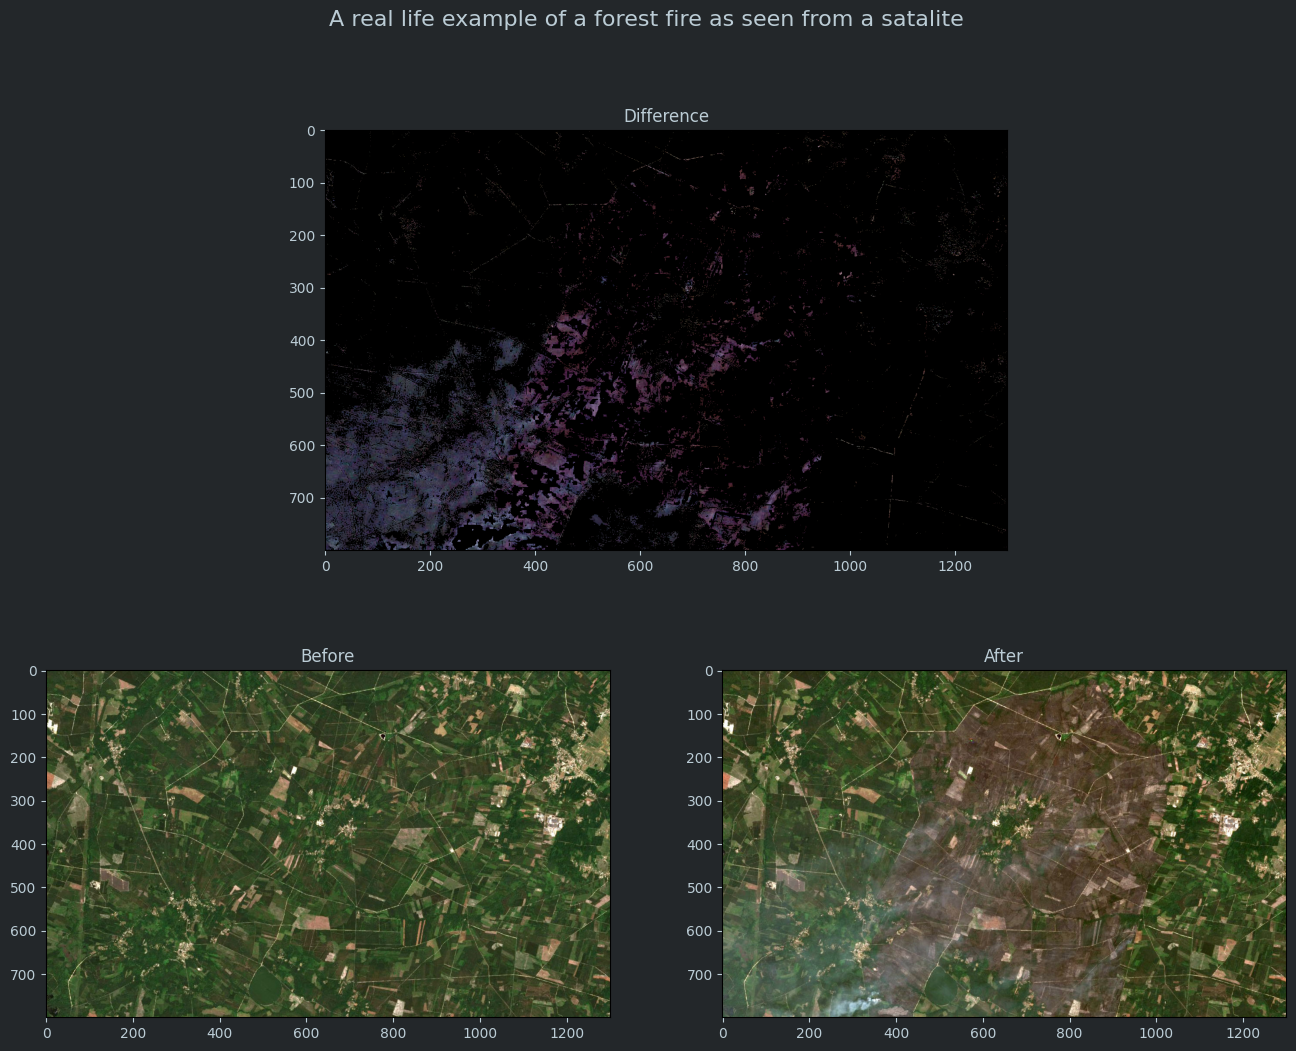

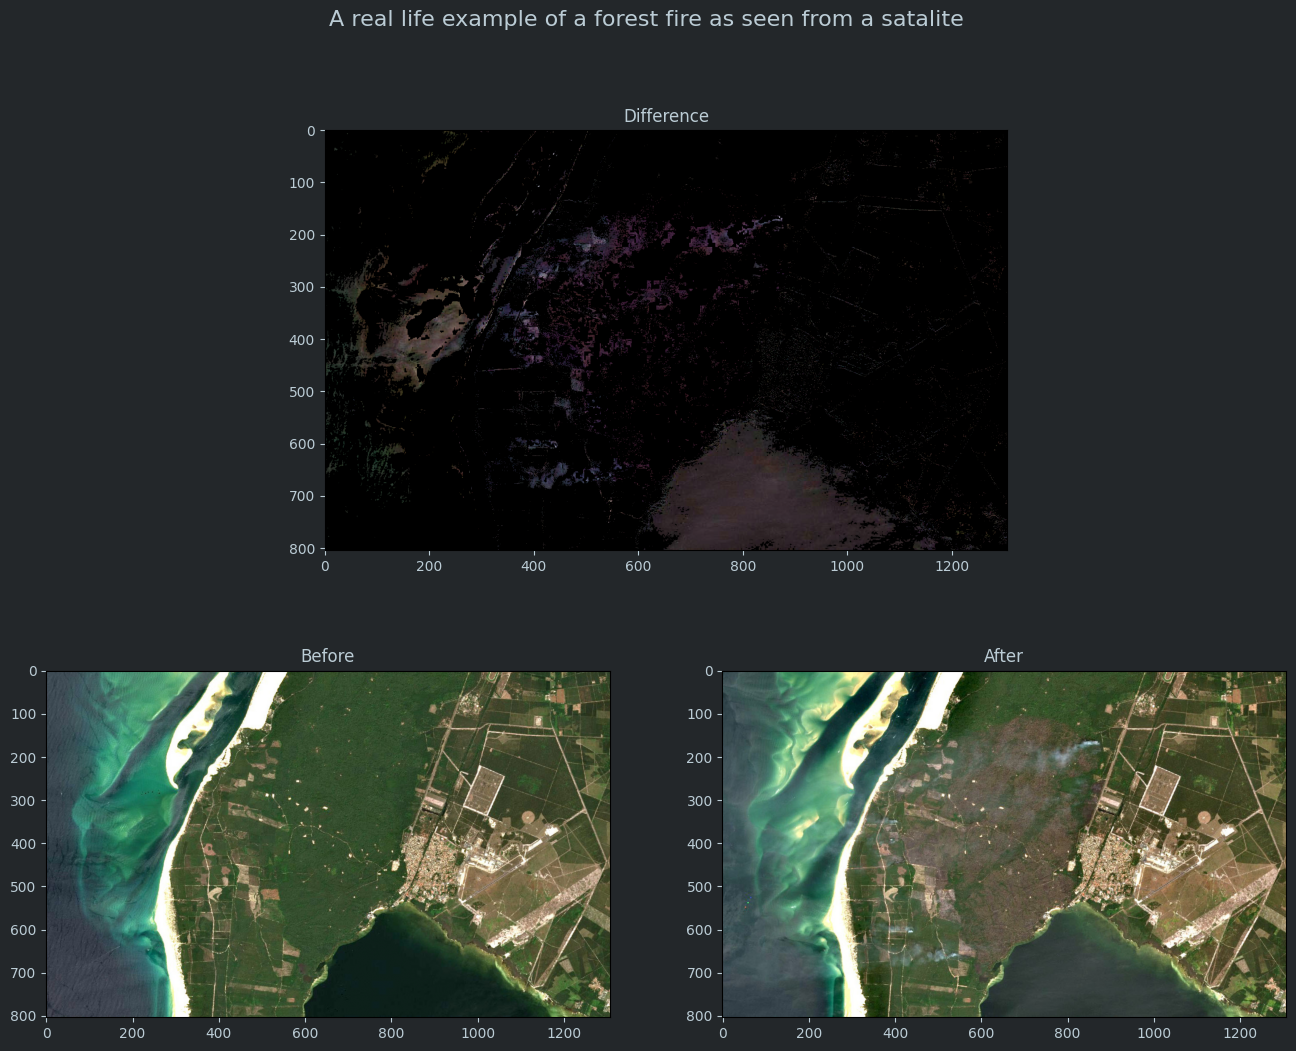

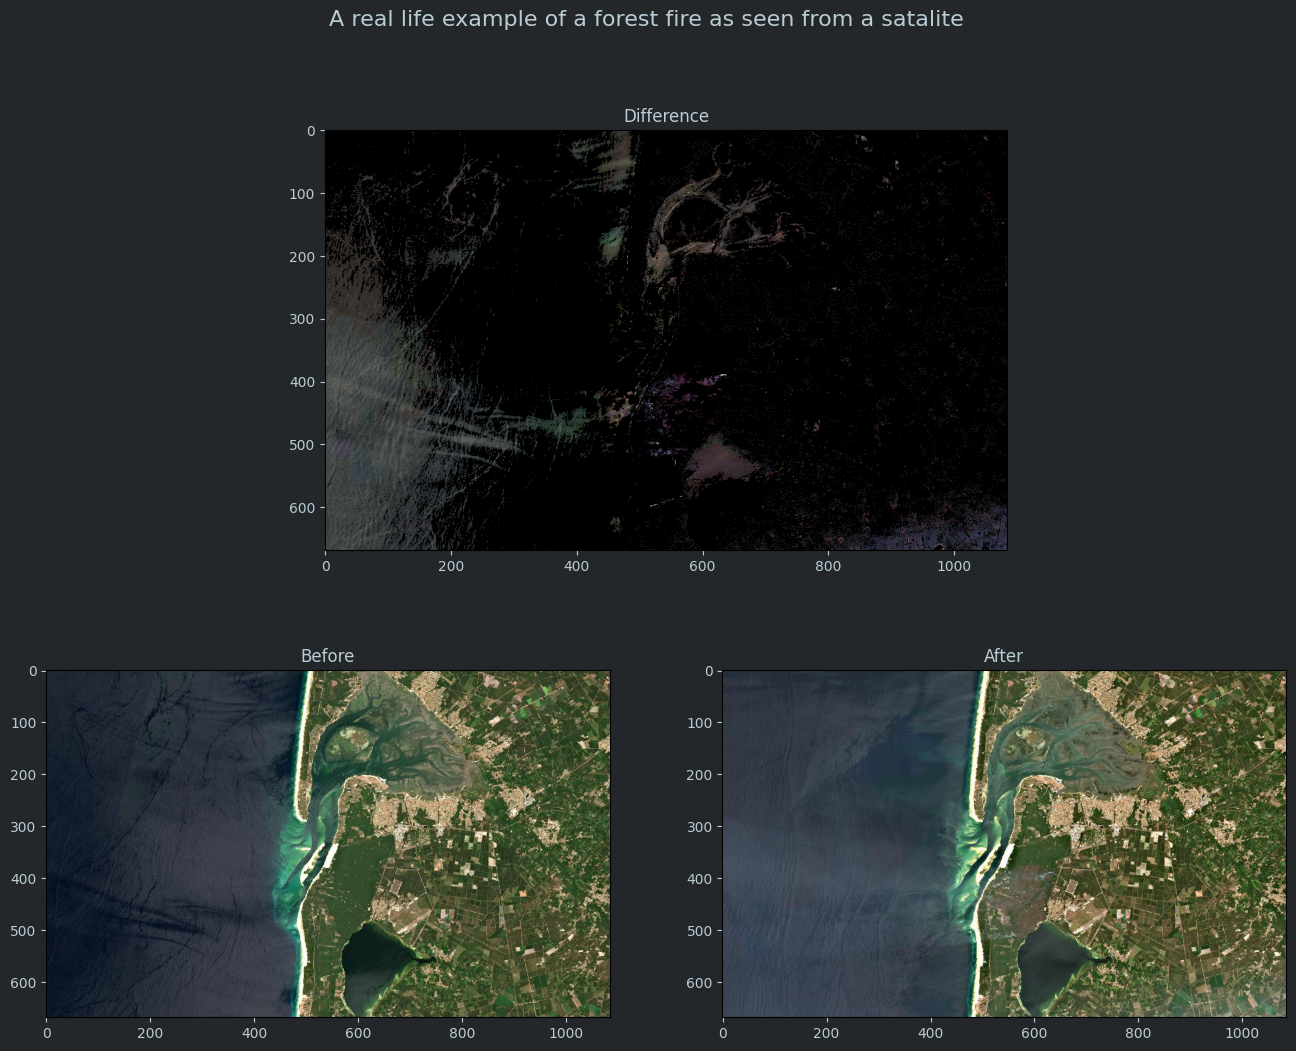

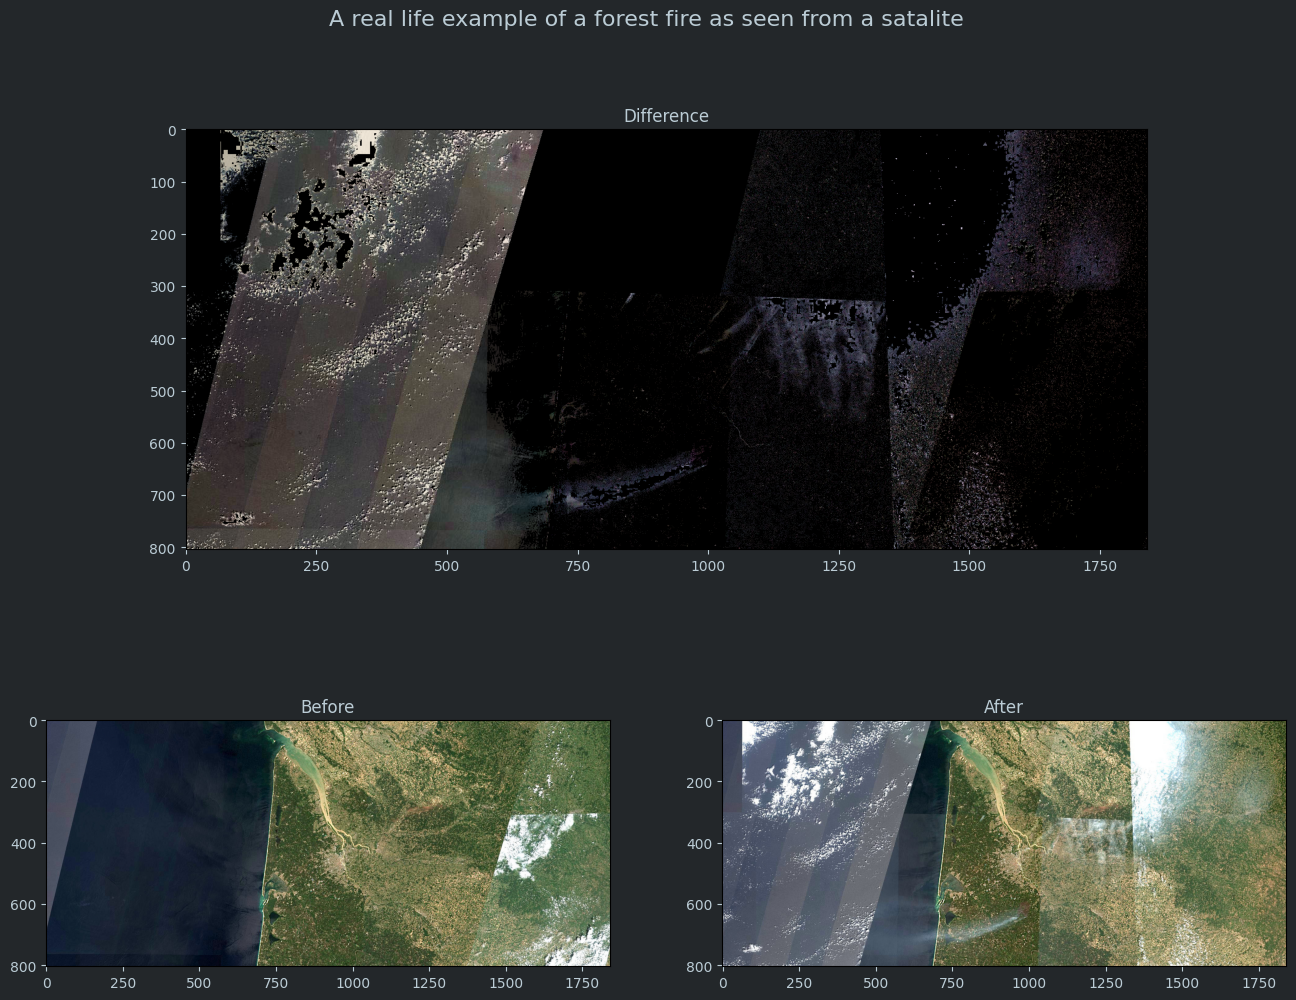

In [6]:
for i, example in enumerate(examples):
    title = 'A real life example of a forest fire as seen from a satalite'
    fig = plot_trio(*example, title=title)
    save_fig(fig, f'{i}-{title}')

## Fire generation

Looking at this specific example I can identify 3 clear patterns of a fire.
1. We have a bright source
2. A dense smoke trail near the source
3. A more spread out smoke plume of smoke further out

From this we can consider some key parameters we would want to have for each:
1. For all
    1. Size
    2. Brightness
2. Source
    1. Shape (e.g. stretched oval and its orientation)
3. Smoke Trail
    1. Width in degrees as it spreads in a sector pattern see below ( or in other terms wind strength) 
    2. Wind direction
4. Other smoke
    1. I see it as potentially perlin noise and hence its relevant settings possibly translated to more meaningful smoke terms
    2. 1 and 2 from Smoke Trail

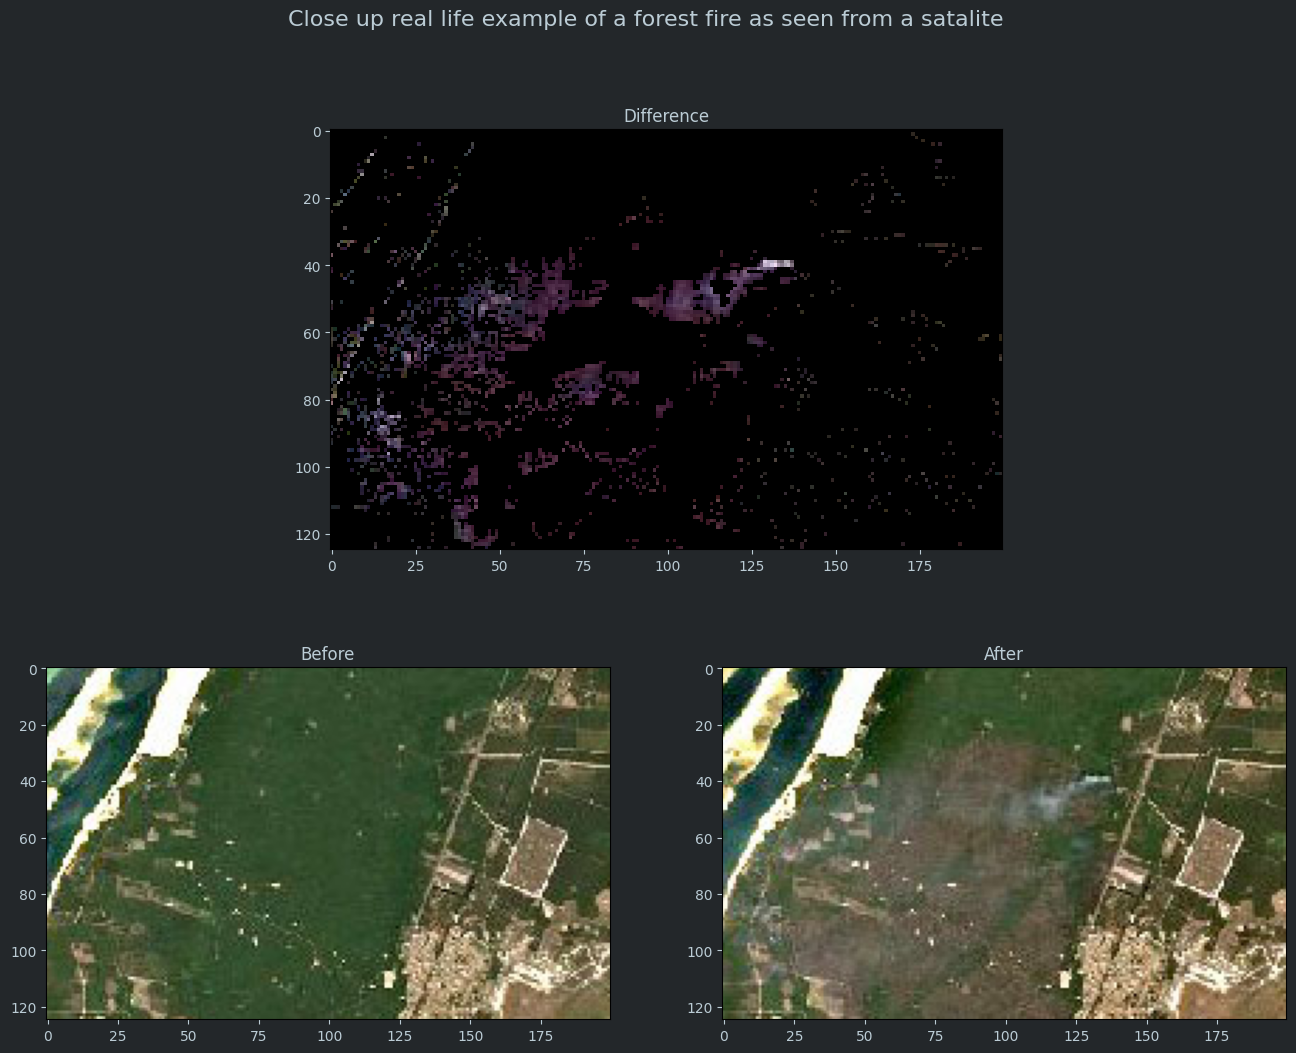

In [7]:
# looking at an example closer up
crop =[img[350:475, 500:700] for img in examples[2]]
title = 'Close up real life example of a forest fire as seen from a satalite'
fig = plot_trio(*crop, title=title)
save_fig(fig, title)

In [8]:
img = examples[2][0][350:475, 500:700] # extract close up image

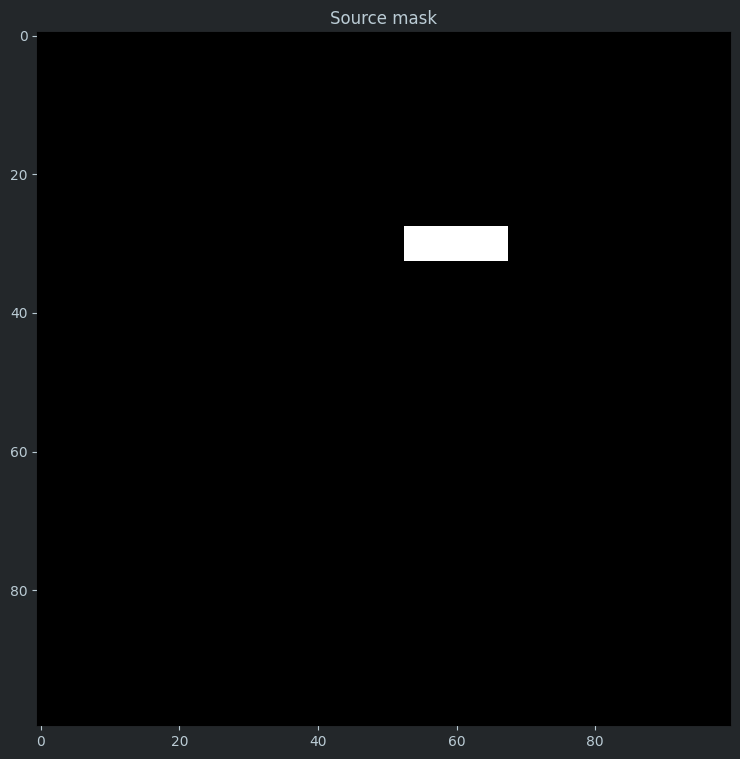

In [9]:
def create_centered_rectangle_mask(size, position, dims):
    circle_mask = np.zeros(size)
    for y in range(circle_mask.shape[0]):
        for x in range(circle_mask.shape[1]):
            if position[1] + dims[1] >= x >= position[1] - dims[1] and position[0] + dims[0] >= y >= position[0] - dims[0]:
                circle_mask[y, x] = 1
    return circle_mask


plt.imshow(create_centered_rectangle_mask((100, 100), (30, 60), (2, 7)), cmap= plt.cm.bone)
title = 'Source mask'
plt.title(title)
save_fig(None, title)

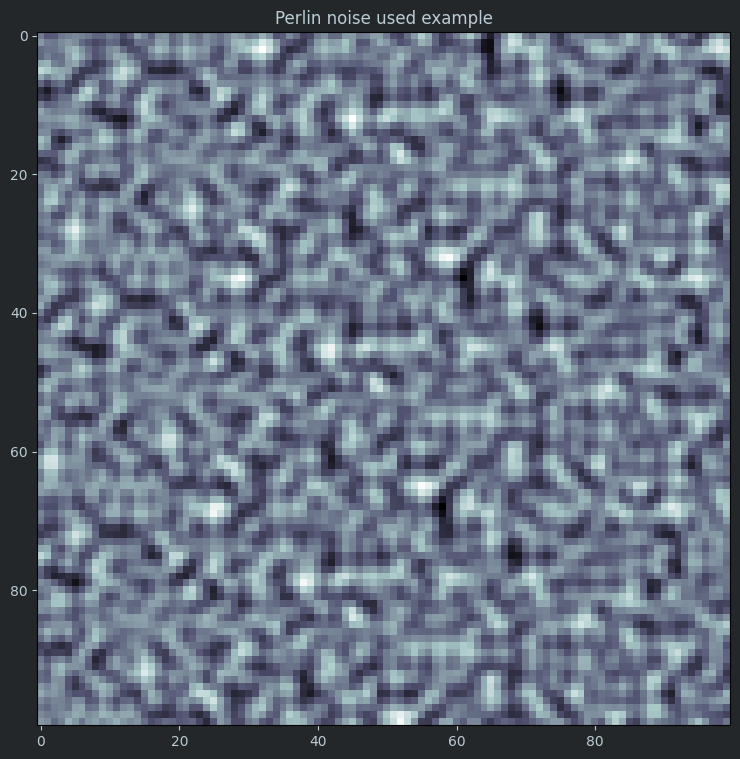

In [10]:
noise = PerlinNoise(octaves=30)
xpix, ypix = (100, 100)
smoke = scale_values(np.array([[noise([i/xpix, j/ypix]) for j in range(ypix)] for i in range(xpix)]))
plt.imshow(scale_values(smoke), cmap=plt.cm.bone)
title = 'Perlin noise used example'
plt.title(title)
save_fig(None, title)

In [ ]:
def insert(target, loc, tool): # there is a np.insert but i could not get it to work
    if len(tool.shape) == 2: # if missing color channel dimention
        tool = expand_to_rgb(tool)
        
    copy = target.copy()
    copy[loc[0]: loc[0] + tool.shape[0], loc[1]: loc[1] + tool.shape[1], :] = tool
    return copy

def generate_source(img, position, brightness, size, shape):
    noise = PerlinNoise(octaves=60)
    xpix, ypix = img.shape[:2]
    smoke = scale_values(np.array([[noise([i/xpix, j/ypix]) for j in range(ypix)] for i in range(xpix)]))
    
    
    
    mask = create_centered_rectangle_mask(img.shape[:2], position, (size * shape, size))
    # mask = cv2.GaussianBlur(mask, (11,11), cv2.BORDER_DEFAULT)
    blr_size = max(int(size * 0.3), 2)
    mask = cv2.blur(mask, (blr_size,blr_size))
    
    source = expand_to_rgb(smoke * mask) * brightness
    
    return source

source = generate_source(img, (40, 125), 1.5, 5, 2/7)
plt.imshow(clip(img + source))
title = 'Source applied to the image'
plt.title(title)
save_fig(None, title)

In [ ]:

def create_cone_mask(size, position, width, direction):
    cone_mask = np.zeros(size)
    # create the two angles adding an offest for each edge of the cone as well as rotating to bearing coordinates i.e. 0deg is north
    angle1, angle2 = direction - width / 2 - np.pi / 2, direction + width / 2 - np.pi / 2
    # calcluate the gradient line given the angle
    gradient_boundary1, gradient_boundary2 = np.tan( angle1), np.tan(angle2)
    for y in range(cone_mask.shape[0]):
        for x in range(cone_mask.shape[1]):
            # get the side that the pixel is on for both lines
            divide1, divide2 = (y - position[0]) <= gradient_boundary1 * (x - position[1]), y - position[0] >= gradient_boundary2 * (x - position[1])
            # combine with threshold function that tells us if we want the space above or below the dividing line "sin(theta - pi/2) >= 0"
            if not( (divide1 != (np.sin(angle1 - np.pi / 2) >= 0)) or (divide2 != (np.sin(angle2 - np.pi / 2) >= 0))):
                cone_mask[y, x] = 1
    
    return cone_mask


fig = plt.figure()
items = 12
for i in range(1, items + 1):
    direction = 2 * np.pi * i / items / 12
    ax = fig.add_subplot(4, 4, i + 1, title=f'{np.rad2deg(direction):0.0f}°')
    ax.imshow(create_cone_mask((100, 100), (50, 50), direction, np.deg2rad(45)), cmap=plt.cm.bone)



In [ ]:
def create_circle_mask(size, position, radius):
    circle_mask = np.zeros(size)
    for y in range(circle_mask.shape[0]):
        for x in range(circle_mask.shape[1]):
            if radius ** 2 > (x - position[1]) ** 2 + (y - position[0]) ** 2:
                circle_mask[y, x] = 1
    return circle_mask

plt.imshow(create_circle_mask((100, 100), (30, 60), 20), cmap= plt.cm.bone)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.imshow(create_centered_rectangle_mask((100, 100), (30, 60), (2, 7)), cmap= plt.cm.bone)
ax1.set_title('Source mask')
ax2.imshow(create_cone_mask((100, 100), (30, 60), 1, np.deg2rad(250)), cmap=plt.cm.bone)
ax2.set_title('Cone mask for trail and plume')
ax3.imshow(create_circle_mask((100, 100), (30, 60), 20), cmap= plt.cm.bone)
ax3.set_title('Circle mask for trail and plume')

title = 'All of the masks used for fire generation'
fig.suptitle(title)
save_fig(fig, title)

In [ ]:
def generate_trail(img, position, brightness, width, direction, radius):
    trail = np.zeros_like(img)
    
    
    noise = PerlinNoise(octaves=30)
    xpix, ypix = img.shape[:2]
    smoke = scale_values(np.array([[noise([i/xpix, j/ypix]) for j in range(ypix)] for i in range(xpix)]))
    
    
    cone_mask = create_cone_mask(img.shape[:2], position, width, direction)
    circle_mask = create_circle_mask(img.shape[:2], position, radius)
    
    mask = cone_mask * circle_mask
    # mask = cv2.GaussianBlur(mask, (11,11), cv2.BORDER_DEFAULT)
    blr_size = int(radius * 0.3)
    mask = cv2.blur(mask, (blr_size,blr_size))
    
    trail = expand_to_rgb(smoke * mask) * brightness
    
    return trail

trail = generate_trail(img, (40, 125), 2, np.deg2rad(15), np.deg2rad(250), 30)
plt.imshow(clip(img + trail))

title = 'Trail applied to the image'
plt.title(title)
save_fig(None, title)

In [ ]:
def generate_plume(img, position, brightness, width, direction, radius):
    plume = np.zeros_like(img)
    
    
    noise = PerlinNoise(octaves=10)
    xpix, ypix = img.shape[:2]
    smoke = scale_values(np.array([[noise([i/xpix, j/ypix]) for j in range(ypix)] for i in range(xpix)]))
    
    
    cone_mask = create_cone_mask(img.shape[:2], position, width, direction)
    circle_mask = create_circle_mask(img.shape[:2], position, radius)
    
    mask = cone_mask * circle_mask
    # mask = cv2.GaussianBlur(mask, (11,11), cv2.BORDER_DEFAULT)
    blr_size = int(radius * 0.3)
    mask = cv2.blur(mask, (blr_size,blr_size))
    
    plume = expand_to_rgb(smoke * mask) * brightness
    
    return plume

plume = generate_plume(img, (40, 125), 0.4, np.deg2rad(60), np.deg2rad(250), 100)
plt.imshow(clip(img + plume))

title = 'Plume applied to the image'
plt.title(title)
save_fig(None, title)

In [ ]:
def generate_fire(img, position, direction, blue=1.2): # TODO: add wind speed which translates to width for trail and plume
    source = generate_source(img, position, 0.8, 4, 1/4)
    trail = generate_trail(img, position, 1, np.deg2rad(15), direction, 30)
    plume = generate_plume(img, position, 0.2, np.deg2rad(60), direction, 150)
    fire = source + trail + plume
    fire[:, : ,2] *= blue # boost blue channel
    return clip(img + fire)

img_with_fire = generate_fire(img, (40, 125), np.deg2rad(250))

title = 'Comparison between original fire and generated fire'
fig = plot_trio(img_with_fire, crop[1], clip(img_with_fire - crop[1]), labels=('Generated', 'Real', 'Difference'), title=title)
save_fig(fig, title)

In [ ]:
def generate_fire_demo(img, position, direction, blue=1.2): # TODO: add wind speed which translates to width for trail and plume
    source = generate_source(img, position, 0.8, 4, 1/4)
    trail = generate_trail(img, position, 1, np.deg2rad(15), direction, 30)
    plume = generate_plume(img, position, 0.2, np.deg2rad(60), direction, 150)
    source[:, : ,2] *= blue # boost blue channel
    trail[:, : ,2] *= blue # boost blue channel
    plume[:, : ,2] *= blue # boost blue channel
    return clip(img + source), clip(img + trail), clip(img + plume)

s, t, p = generate_fire_demo(img, (40, 125), np.deg2rad(250))

title = 'Demo of separate features'
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16, 4))
ax1.imshow(s)
ax1.set_title('Source')
ax2.imshow(t)
ax2.set_title('Trail')
ax3.imshow(p)
ax3.set_title('Plume')
fig.suptitle(title, fontsize=16)

save_fig(fig, title)

#### OLD DEPRICATED SOLUTION FOR LOCATION SELECTION

In [ ]:

def get_random_position(img):
    # temporary solution for any random green pixel.
    # TODO: find a way to not generate fire on water bodies
    mask = img[:, :, 1] < 0.5
    # plt.imshow(mask, cmap=plt.cm.bone)
    y, x = np.where(mask)
    index = np.random.randint(len(x))
    return y[index], x[index]

get_random_position(img)


In [ ]:
fig = plt.figure(figsize=(20, 15))

for i in range(12):
    pos = get_random_position(img)
    ax = fig.add_subplot(4, 3, i + 1, title=f'Placed at {pos}')
    ax.imshow(generate_fire(img, pos, np.deg2rad(250)))

### Converting angle inputs into a single wind value

In [ ]:
def scale_variable(value,target_min=0, target_max=1, a_min=0, a_max=1):
    return (value - a_min) / (a_max - a_min) * (target_max - target_min) + target_min

def calculate_wind(size, wind):

    diag = np.sqrt(size[0] ** 2 + size[1] ** 2)
    trail_angle = np.deg2rad(scale_variable(wind, 30, 10))
    trail_length = scale_variable(wind, diag / 20, diag / 4)
    
    plume_angle = np.deg2rad(scale_variable(wind, 180, 40))
    plume_length = scale_variable(wind, diag / 5, diag / 1)
    
    return (trail_angle, trail_length), (plume_angle, plume_length)


def generate_fire_with_wind(img, position, direction, wind, blue=1.2):
    trail_params, plume_params = calculate_wind(img.shape, wind)
    source = generate_source(img, position, 0.8, 4, 1/4)
    trail = generate_trail(img, position, 1, trail_params[0], direction, trail_params[1])
    plume = generate_plume(img, position, 0.2, plume_params[0], direction, plume_params[1])
    fire = source + trail + plume
    fire[:, : ,2] *= blue # boost blue channel
    return clip(img + fire)

fig = plt.figure(figsize=(20, 15))
for i in range(12):
    wind = (i + 1) / 12
    ax = fig.add_subplot(4, 3, i + 1, title=f'Wind {wind:0.2f}')
    ax.imshow(generate_fire_with_wind(img, (40, 125), np.deg2rad(250), wind))
    
title = 'Demo of different wind strength values'
fig.suptitle(title, fontsize=16)
save_fig(fig, title)

## Mass Generation support functions

In [ ]:
class Randomizer:

    def __init__(self, variables):
        # variables is a dictionary of variable settings in the form (distribution, distribution specific settings...)
        self.variables = variables
        self._distributions = {
            'range': self._rand,
            'intrange': self._randint,
            'normal': self._norm,
            'truncated_normal': self._trunc_norm,
        }
    
    def get(self, *variables): # get a random value for each variable
        if len(variables) == 1:
            return self._get(variables[0])
        return [self._get(variable) for variable in variables]
    
    # private functions
    
    def _get(self, variable):
        if variable in self.variables:
            distribution, *settings = self.variables[variable]
            return self._distributions[distribution](*settings)
        else:
            raise Exception(f'Variable {variable} is not defined')
        
    # Distribution functions
    
    def _rand(self, lower, upper):
        return random.random() * (upper - lower) + lower
    
    def _randint(self, lower, upper):
        return random.randint(lower, upper)
    
    def _norm(self, mean, std):
        return random.gauss(mu=mean, sigma=std)
    
    def _trunc_norm(self, mean, std, lower, upper):
        for _ in range(1000): # try a 1000 times error out if lower and upper are too unlikely
            value = self._norm(mean, std)
            if lower <= value < upper:
                return value
        raise Exception(f'Boundaries {lower} - {upper} are too unlikely for mean {mean} and std {std}')

### Finding applicable position for fire

1. Convert image to the HSV color space
2. Mask out non green colors
3. Mask out un saturated green colors
4. Mask out extremely bright and extremely dark values
5. Filter out noisy low density locations


In [ ]:
def find_burnable_pos(img, randomizer, demo=False):
    hsv_img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_RGB2HSV)
    
    green_mask = (100 < hsv_img[:, : ,0]) & (hsv_img[:, : ,0] < 140) # filter non gree spots
    saturation_mask = (0.2 < hsv_img[:, : ,1]) # filter light green
    luminance_mask = (0.1 < hsv_img[:, : ,2]) & (hsv_img[:, : ,2] < 0.9) # filter extreme bright and dark spots
    burnable_mask = green_mask & saturation_mask & luminance_mask
    
    final_mask = cv2.blur(burnable_mask.astype(float), (5,5)) > 0.7 # remove noisy single pixel areas
    
    # search for a compatable random value
    for _ in range(1000):
        pos = tuple(map(int, randomizer.get('pos_y', 'pos_x')))
        if final_mask[*pos]:
            break
    else:
        pos = None # no position found return None this image can not have a fire on it
    
    # run demontstration if enabled
    if demo:
        marked_img = img.copy()
        if pos:
            marked_img[*pos] = (1, 0, 1)
        demos = {
            f'original and also final position which is {pos}': marked_img,
            'green mask': expand_to_rgb(green_mask) * img,
            'saturation mask': expand_to_rgb(saturation_mask) * img,
            'luminance mask': expand_to_rgb(luminance_mask) * img,
            'burnable mask': expand_to_rgb(burnable_mask) * img,
            'final mask': expand_to_rgb(final_mask) * img,
        }
        fig = plt.figure(figsize=(20, 10))
        for i, (demo_name, demo_img) in enumerate(demos.items()):
            ax = fig.add_subplot(2, 3, i + 1, title=demo_name)
            ax.imshow(demo_img)
            
        title = f'Finding a burnable position stages for {demo}'
        fig.suptitle(title, fontsize=16)
        save_fig(fig, title)
            
    return pos 

find_burnable_pos(img, 
                  Randomizer({
    'pos_x': ('intrange', 5, img.shape[1] - 5),
    'pos_y': ('intrange', 5, img.shape[0] - 5),}), 
                  demo='original image'
                 )

### Spectrum demo

In [ ]:
spectrum_image = get_img('spectrum_chart.jpg')
find_burnable_pos(spectrum_image, 
                  Randomizer({
    'pos_x': ('intrange', 5, spectrum_image.shape[1] - 5),
    'pos_y': ('intrange', 5, spectrum_image.shape[0] - 5),}), 
                  demo='spectrum image'
                 )

### Final fire generation function with randomizer integration

In [ ]:
def generate_fire(img, position, direction, wind, randomizer, blue=1.2):
    trail_params, plume_params = calculate_wind(img.shape, wind)
    source = generate_source(img, position, randomizer.get('source_strength'), 4, 1/4)
    trail = generate_trail(img, position, randomizer.get('trail_strength'), trail_params[0], direction, trail_params[1])
    plume = generate_plume(img, position, randomizer.get('plume_strength'), plume_params[0], direction, plume_params[1])
    fire = source + trail + plume
    fire[:, : ,2] *= blue # boost blue channel
    return clip(img + fire)

### Setup distributions for all random variables

In [ ]:
image_boundary = 10
variables = {
    'pos_x': ('truncated_normal', 128, 64, image_boundary, 256 - image_boundary),
    'pos_y': ('truncated_normal', 128, 64, image_boundary, 256 - image_boundary),
    'wind_direction': ('range', 0, np.pi * 2),
    'wind_strength': ('truncated_normal', 0.5, 0.3, 0, 1),
    'blue_boost': ('normal',1.2 , 0.02),
    'source_strength': ('normal', 0.7, 0.04),
    'trail_strength': ('normal', 1.1, 0.04),
    'plume_strength': ('normal', 0.3, 0.04)
}

demo_randomizer = Randomizer(variables)

fig = plt.figure(figsize=(20, 14))
for i, variable in enumerate(variables):
    results = [demo_randomizer.get(variable) for _ in range(10000)]
    ax = fig.add_subplot((len(variables)+ 1)// 2, 2, i + 1, title=variable)
    ax.hist(results)
    
title = 'Random Variable distributions used for fire generation'
fig.suptitle(title, fontsize=16)
save_fig(fig, title)

## Generate final dataset

In [ ]:
images = []
for path, dirnames, filenames in os.walk(os.path.join('..','datasets','raw')):
    if not filenames: # skip empty directory
        continue
    for filename in filenames:
        full_path = os.path.join(path, filename)
        images.append((os.path.basename(path), filename[:-4], full_path))
        
print(f'{len(images)} images found')
print(f'\nTwo samples:\nSource , image name , full path\n{images[0]}\n{images[-1]}')

random.shuffle(images)

In [ ]:
def generate_dataset(images, num_positive=1000):
    c_skipped, c_positive, c_negative = 0, 0, 0
    if os.listdir(os.path.join('..','datasets','generated')):
        print('Files found in "/datasets/generated" ending process. Delete old dataset before generating a new one!')
        return
    
    #Create empty metadata DataFrame
    recorded_values = ['pos_y', 'pos_x', 'wind_direction', 'wind_strength']
    df = pd.DataFrame(columns=['img_name', 'img_source', 'fire', *recorded_values])
    
    rd = Randomizer(variables)
    
    for i, (img_source, img_name, img_path) in enumerate(images):
        is_positive = False
        img = cv2.imread(img_path)
        
        img = cv2.normalize(img, np.zeros_like(img), 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
        
        if img.shape != (256, 256):
            if img.shape[0] != img.shape[1]:
                print(f'image {img_name} is not square dropping')
                c_skipped += 1
                continue
            else:
                img = cv2.resize(img, (256, 256))
        if num_positive: # do we need more fire images
            
            # attempt to find a suitable location for fire
            pos = find_burnable_pos(img, rd)
            if pos is not None:
                # generate other high lever parameters 
                wind_direction, wind_strength, blue_boost = rd.get('wind_direction', 'wind_strength', 'blue_boost')
                img = generate_fire(img, pos, wind_direction, wind_strength, rd, blue=blue_boost)
                is_positive = True
                num_positive -= 1
                
        indexed_image_reference = f'{str(i).rjust(int(np.log10(len(images)) + 1), "0")}-{img_name}'
        if is_positive:
            df.loc[len(df.index)] = [indexed_image_reference, img_source, is_positive, *pos, wind_direction, wind_strength]
            c_positive += 1
        else:
            df.loc[len(df.index)] = [indexed_image_reference, img_source, is_positive, *(np.nan for _ in range(len(recorded_values)))]
            c_negative += 1
        save_path = os.path.join('..','datasets','generated', indexed_image_reference + '.jpg')
        cv2.imwrite(save_path, img * 256)
        
        if not (i + 1) % 70:
            print('.', end='')
        if not (i + 1) % 700:
            print('|', end='')
            
    df.to_csv(os.path.join('..','datasets','generated_metadata.csv'))
    
    print('\nCompleted!')
    print(f'\npositive images:\t{c_positive}\nnegative images:\t{c_negative}\nskipped images: \t{c_skipped}')
        
generate_dataset(images)